In [1]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from matplotlib import  rc
rc('text', usetex=False)

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [6]:
#prefix = '/home/bhalla/Documents/Codes/data'
prefix = ''
currentClampFiles = prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/normalization_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()
dirnames = ['/media/sahil/NCBS_Shares_BGStim/patch_data/190220/c2/', '/media/sahil/NCBS_Shares_BGStim/patch_data/190220/c3/', '/media/sahil/NCBS_Shares_BGStim/patch_data/190220/c4/','/media/sahil/NCBS_Shares_BGStim/patch_data/190220/c5/']
#dirnames = ['/media/sahil/Clean/190220/c2/', '/media/sahil/Clean/190220/c3/', '/media/sahil/Clean/190220/c4/', '/media/sahil/Clean/190220/c5/' ]

In [7]:
neurons = {}

for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = prefix + dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    if n:
        neurons[str(n.date) + '_' + str(n.index)] = n

In [8]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}

In [9]:
control_result2_rsquared_adj = []
control_result1_rsquared_adj = []
control_var_expected = []
gabazine_result2_rsquared_adj = []
gabazine_result1_rsquared_adj = []
gabazine_var_expected = []
tolerance = 5e-4

In [10]:
def linearModel(x, beta=100):
    # Linear model
    return (x*(1-beta))

def DN_model(x, alpha=1, beta=1, gamma=1):
    # Divisive normalization modelg
    #return x - a*(x**2)/(b+x)
    #return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)
    return (gamma*x)/(x+gamma)
    
#     exc = 65
#     A = 1 - np.exp(-x/alpha)
#     B = beta*(1 - np.exp(-x/alpha))
# #     A = beta*(np.exp(x-alpha)-1)
# #     B = gamma*(np.exp(x-alpha)-1)
# #     A = (1 + np.tanh(x - alpha))/2
# #     B = np.abs(beta)*(1 + np.tanh((x - alpha)))/2
#     G = exc/(B-A-A*B)
#     return x/((x/G) + 1)
    
    #return (gamma*x *(1 + np.exp(-alpha*x)))/(x+gamma)
    #B = (1 + np.tanh((x - alpha)))/2
    #np.exp((1-alpha)*x)
    #B = beta * (np.exp(x)-1)
    #return (gamma*x + alpha*np.tanh(-x) - beta*(1-alpha*np.tanh(-x)))/(1 + gamma*x)
    #return (beta*x *(1 + (alpha*np.tanh(x))))/(x *(beta*alpha*np.tanh(x) + beta - 1) + 1)

In [11]:
def findThreshold(trace, thresVal=0.1):
    ''' This returns the action potential threshold '''
    peakIndex = np.argmax(trace)
    slope = np.diff(trace[:peakIndex])
    maxSlope = np.max(slope)
#     print("values are ", np.where(slope>thresVal*maxSlope)[0])
    threshold = trace[np.where(slope>thresVal*maxSlope)[0][0]]
    return threshold

## 4 B Divisive Normalization representative cell

In [29]:
neuron = neurons['190220_c3']

In [30]:
neuron.features

{0: 'epsp_max',
 1: 'epsp_area',
 2: 'epsp_avg',
 3: 'epsp_time_to_peak',
 4: 'epsp_area_to_peak',
 5: 'epsp_min',
 6: 'epsp_onset',
 7: 'positive_area',
 8: 'positive_time'}

In [31]:
feature = 5 # Area under the curve
expected, observed, g_expected, g_observed = {}, {}, {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == 2):
        for sqr in exp:
            if sqr > 1:
                expected[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            expected[sqr].append(-exp[sqr].coordwise[coord].expected_feature[feature]*1e9)
                            observed[sqr].append(-trial.feature[feature]*1e9)

[[Model]]
    Model(linearModel)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 180
    # variables        = 1
    chi-square         = 49859.472
    reduced chi-square = 278.545
    Akaike info crit   = 1014.321
    Bayesian info crit = 1017.514
[[Variables]]
    beta:   0.58551684 +/- 0.008266 (1.41%) (init= 100)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 180
    # variables        = 3
    chi-square         = 44425.472
    reduced chi-square = 250.991
    Akaike info crit   = 997.550
    Bayesian info crit = 1007.129
[[Variables]]
    alpha:   1          +/- 0        (0.00%) (init= 1)
    beta:    1          +/- 0        (0.00%) (init= 1)
    gamma:   127.584539 +/- 0        (0.00%) (init= 1)



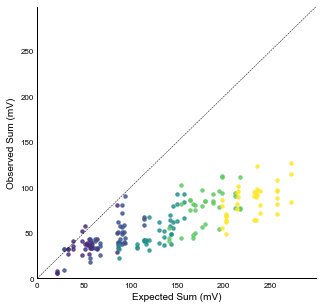

In [32]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []
max_exp, max_g_exp = 0.,0.
fig, ax = plt.subplots()
squareVal = []
list_control_expected = []
list_control_observed = []

for sqr in sorted(observed):
    squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=12))
    max_exp = max(max_exp, max(expected[sqr]))
    list_control_expected += expected[sqr]
    list_control_observed += observed[sqr]
    
X = np.array(list_control_expected)
y = np.array(list_control_observed)
idx   = np.argsort(X)
X = X[idx]
y = y[idx]

linear_Model = lmfit.Model(linearModel)
DN_Model = lmfit.Model(DN_model)

lin_pars = linear_Model.make_params()
lin_result = linear_Model.fit(y, lin_pars, x=X)
lin_aic.append(lin_result.aic)
lin_chi.append(lin_result.redchi)

DN_pars = DN_Model.make_params()
DN_result = DN_Model.fit(y, DN_pars, x=X)
dn_aic.append(DN_result.aic)
dn_chi.append(DN_result.redchi)

print (lin_result.fit_report())
print (DN_result.fit_report())

ax.set_xlim(xmin=0.)
ax.set_ylim(ymin=0.)
ax.set_xlabel("Expected")
ax.set_ylabel("Observed")
ax.set_title("Divisive Normalization and Inhibition fits")
# div_inh = ax.plot(X, lin_result.best_fit, '-', color='green', lw=2)
# div_norm = ax.plot(X, DN_result.best_fit, '-', color='purple', lw=2)


max_exp *=1.1
max_g_exp *=1.1
ax.set_xlim(0,max_exp)

ax.set_ylim(0,max_exp)
# ax.set_ylim(0,0.05)
ax.set_xlabel("Expected Sum (mV)")
ax.set_ylabel("Observed Sum (mV)")
linear = ax.plot((0,max_exp), (0,max_exp), 'k--')

# legends = div_inh + div_norm + linear +  squareVal
# labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\beta$ = {:.2f}, $\\gamma$ = {:.2f}".format(DN_result.params['beta'].value, DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 
labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\gamma$ = {:.2f}".format(DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 

# ax.legend(legends, labels, loc='upper left')

simpleaxis(ax)
fig.set_figwidth(5)
fig.set_figheight(5)
#dump(fig,file('figures/fig4/4b.pkl','wb'))
plt.show()

In [20]:
feature = 0 # Area under the curve
time, observed = {}, {}
for expType, exp in neuron:
    ## Control case
    if(expType == "Control"):
        for sqr in exp:
#             if sqr > 1:
                time[sqr] = []
                observed[sqr] = []
                for coord in exp[sqr].coordwise:
                    for trial in exp[sqr].coordwise[coord].trials:
                        if all([value == 0 for value in trial.flags.values()]):
                            time[sqr].append(trial.feature[3])
                            observed[sqr].append(trial.feature[0])

In [ ]:
lin_aic = []
dn_aic = []
lin_chi = []
dn_chi = []
max_exp, max_g_exp = 0.,0.
fig, ax = plt.subplots()
squareVal = []
list_control_expected = []
list_control_observed = []

for sqr in sorted(observed):
    print(sqr, len(observed[sqr]), len(time[sqr]))
    squareVal.append(ax.scatter(observed[sqr], time[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8, s=12))
#     max_exp = max(max_exp, max(observed[sqr]))
#     list_control_expected += time[sqr]
#     list_control_observed += observed[sqr]
    
# X = np.array(list_control_expected)
# y = np.array(list_control_observed)
# idx   = np.argsort(X)
# X = X[idx]
# y = y[idx]

# linear_Model = lmfit.Model(linearModel)
# DN_Model = lmfit.Model(DN_model)

# lin_pars = linear_Model.make_params()
# lin_result = linear_Model.fit(y, lin_pars, x=X)
# lin_aic.append(lin_result.aic)
# lin_chi.append(lin_result.redchi)

# DN_pars = DN_Model.make_params()
# DN_result = DN_Model.fit(y, DN_pars, x=X)
# dn_aic.append(DN_result.aic)
# dn_chi.append(DN_result.redchi)

# print (lin_result.fit_report())
# print (DN_result.fit_report())

# ax.set_xlim(xmin=0.)
# ax.set_ylim(ymin=0.015, ymax=0.05)
# ax.set_xlabel("Expected")
# ax.set_ylabel("Observed")
# ax.set_title("Divisive Normalization and Inhibition fits")
# div_inh = ax.plot(X, lin_result.best_fit, '-', color='green', lw=2)
# div_norm = ax.plot(X, DN_result.best_fit, '-', color='purple', lw=2)


# max_exp *=1.1
# max_g_exp *=1.1
# # ax.set_xlim(0,max_exp)

# ax.set_ylim(0,max_exp)
# ax.set_ylim(0,0.05)
# ax.set_xlabel("Expected Sum (mV)")
# ax.set_ylabel("Observed Sum (mV)")
# linear = ax.plot((0,max_exp), (0,max_exp), 'k--')
# 
# legends = div_inh + div_norm + linear +  squareVal
# labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\beta$ = {:.2f}, $\\gamma$ = {:.2f}".format(DN_result.params['beta'].value, DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 
# labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\gamma$ = {:.2f}".format(DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 

ax.legend()

simpleaxis(ax)
fig.set_figwidth(5)
fig.set_figheight(5)
# dump(fig,file('figures/fig4/4b.pkl','wb'))
plt.show()

In [ ]:
neuron.features

In [ ]:
fig, ax = plt.subplots()
ax.hist(list_control_observed,bins=30)
simpleaxis(ax)
ax.set_xlabel("Observed sum")
ax.set_ylabel("# patterns")
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
plt.show()

In [ ]:
feature = 0 # Area under the curve
lin_bic = []
dn_bic = []
lin_chi = []
dn_chi = []
beta = []
gamma = []
delta = []
zeta, zeta2 = [], []
AP_thres = {}
g_AP_thres = {}
gamma_DN = {}

for index in neurons:
    print (index)
    neuron = neurons[index]
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            ap_list = []
            for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed[sqr].append(trial.feature[feature])
                            elif trial.flags['AP_flag'] == 1:
#                                 print ("trial had AP", index, trial.index)
#                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                ap_list.append(trial.baseline +  findThreshold(trial.interestWindow))
            if ap_list:
                AP_thres[index] = np.mean(ap_list)
            else:
                AP_thres[index] = np.nan
            max_exp, max_g_exp = 0.,0.

            squareVal = []
            list_control_expected = []
            list_control_observed = []

            for sqr in sorted(observed):
                squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
                max_exp = max(max_exp, max(expected[sqr]))
                list_control_expected += expected[sqr]
                list_control_observed += observed[sqr]

            X = np.array(list_control_expected)
            y = np.array(list_control_observed)
            idx   = np.argsort(X)
            X = X[idx]
            y = y[idx]

            linear_Model = lmfit.Model(linearModel)
            DN_Model = lmfit.Model(DN_model)

            lin_pars = linear_Model.make_params()
            lin_result = linear_Model.fit(y, lin_pars, x=X)
            lin_bic.append(lin_result.bic)
            lin_chi.append(lin_result.redchi)
            beta.append(lin_result.params['beta'])

            DN_pars = DN_Model.make_params()
#             print (y,X,DN_pars)
            
            try:
                DN_result = DN_Model.fit(y, DN_pars, x=X)
            except:
                print(y,X)
            dn_bic.append(DN_result.bic)
            dn_chi.append(DN_result.redchi)
            gamma.append(DN_result.params['gamma'])
            delta.append(DN_result.params['beta'])
        gamma_DN[index] = DN_result.params['gamma'].value
        if(expType == "GABAzine"):
            ap_list = []
            for sqr in exp:
                if sqr > 1:
#                     expected[sqr] = []
#                     observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                pass
#                                 expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
#                                 observed[sqr].append(trial.feature[feature])
                            elif trial.flags['AP_flag'] == 1:
#                                 print ("trial had AP", index, trial.index)
#                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                ap_list.append(trial.baseline + findThreshold(trial.interestWindow))
#             if ap_list:
#                 AP_thres.append(np.mean(ap_list))
#             else:
#                 AP_thres.append(np.nan)
                
            if ap_list:
                g_AP_thres[index] = np.mean(ap_list)
            else:
                g_AP_thres[index] = np.nan

#             max_exp, max_g_exp = 0.,0.

#             squareVal = []
#             list_control_expected = []
#             list_control_observed = []

#             for sqr in sorted(observed):
#                 squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
#                 max_exp = max(max_exp, max(expected[sqr]))
#                 list_control_expected += expected[sqr]
#                 list_control_observed += observed[sqr]

#             X = np.array(list_control_expected)
#             y = np.array(list_control_observed)
#             idx   = np.argsort(X)
#             X = X[idx]
#             y = y[idx]

#             linear_Model = lmfit.Model(linearModel)
#             DN_Model = lmfit.Model(DN_model)

#             lin_pars = linear_Model.make_params()
#             lin_result = linear_Model.fit(y, lin_pars, x=X)
#             lin_bic.append(lin_result.bic)
#             lin_chi.append(lin_result.redchi)
#             beta.append(lin_result.params['beta'])

#             DN_pars = DN_Model.make_params()
# #             print (y,X,DN_pars)
            
#             try:
#                 DN_result = DN_Model.fit(y, DN_pars, x=X)
#             except:
#                 print(y,X)
#             dn_bic.append(DN_result.bic)
#             dn_chi.append(DN_result.redchi)
#             gamma.append(DN_result.params['gamma'])
#             delta.append(DN_result.params['beta'])
#             print (np.mean(ap_list))

In [ ]:
fig, ax = plt.subplots()
for index in AP_thres.keys():
    ax.scatter(gamma_DN[index], AP_thres[index], s=12)
    print(index, gamma_DN[index], AP_thres[index])
ax.set_xlabel("$\gamma$")
ax.set_ylabel("Threshold")
# ax.set_xlim(xmin=-10.,xmax=10)
# ax.set_ylim(ymin=5.,ymax=17)
simpleaxis(ax)
fig.set_figwidth(2)
fig.set_figheight(2)
plt.show()

In [ ]:
fig, ax = plt.subplots()
for index in g_AP_thres.keys():
    ax.scatter(gamma_DN[index], g_AP_thres[index], s=12)
    print(index, gamma_DN[index], g_AP_thres[index])
ax.set_xlabel("$\gamma$")
ax.set_ylabel("Threshold")
# ax.set_xlim(xmin=-10.,xmax=10)
# ax.set_ylim(ymin=5.,ymax=17)
simpleaxis(ax)
fig.set_figwidth(2)
fig.set_figheight(2)
plt.show()

In [ ]:
allKeys = set(AP_thres.keys()).union(set(g_AP_thres.keys()))

In [ ]:
commonKeys = (set(AP_thres.keys()).intersection(set(g_AP_thres.keys())))

In [ ]:
allDict = {}
for key in commonKeys:
    if not (np.isnan(AP_thres[key]) and np.isnan(g_AP_thres[key])):
        allDict[key] = np.nanmean(AP_thres[key], g_AP_thres[key])
for key in AP_thres.keys():
    if 

## 4 C (Chi-squares population)

In [ ]:
indices = [1,2]
fig, ax = plt.subplots()

for ind, (l,d) in enumerate(zip(lin_chi, dn_chi)):
    ax.plot(indices, [l,d], 'o-', alpha=0.4, color='0.5', markerfacecolor='white')
# ax.violinplot([lin_chi,dn_chi], indices)

# notch shape box plot
bplot = ax.boxplot([lin_chi,dn_chi],
                         notch=True,  # notch shape
#                          vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

colors = ['green', 'purple']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1.)

ax.hlines(1, 0,3, linestyles='--', alpha=1)
# ax.boxplot(, [1])

# ax.set_xlim((-1,2))
ax.set_ylim((-1,7))
ax.set_xticks(indices)
ax.set_xticklabels(('DI', 'DN'))
ax.set_title("Reduced chi-square values for DI and DN")
simpleaxis(ax)

print(ss.ttest_rel(lin_chi, dn_chi))

y, h, col = np.max(lin_chi), 0.5, 'k'
plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "***", ha='center', va='bottom', color=col)

fig.set_figwidth(3)
fig.set_figheight(3)
#dump(fig,file('figures/fig4/4c.pkl','wb'))
plt.savefig('figures/fig4/4c.svg')
plt.show()

In [ ]:
ratio_models = np.array(lin_chi)/np.array(dn_chi)

In [ ]:
fig, ax = plt.subplots()
bins = np.linspace(0.8,2.4,9)
ax.hist(ratio_models,bins=bins)
ax.set_ylabel("# neurons")
#ax.set_xlim(0,3)
ax.vlines(1,0,15,'r','--')
simpleaxis(ax)

left, bottom, width, height = [0.5, 0.4, 0.3, 0.5]
ax2 = fig.add_axes([left, bottom, width, height])
simpleaxis(ax2)
indices = [1,2]

for ind, (l,d) in enumerate(zip(lin_chi, dn_chi)):
    ax2.plot(indices, [l,d], 'o-', alpha=0.4, color='0.5', markerfacecolor='white', markersize=3)
# ax.violinplot([lin_chi,dn_chi], indices)

# notch shape box plot
bplot = ax2.boxplot([lin_chi,dn_chi],
                         notch=True,  # notch shape
                        vert=True,   # vertical box aligmnent
                         patch_artist=True, widths=[0.3,0.3])   # fill with color

colors = ['green', 'purple']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1.)
for patch in (bplot['fliers']):
    patch.set_alpha(0)
ax2.hlines(1, 0,3, linestyles='--', alpha=1)
# ax.boxplot(, [1])

# ax.set_xlim((-1,2))
ax2.set_ylim((-1,7))
ax2.set_xticks(indices)
ax2.set_xticklabels(('DI', 'DN'))
ax2.set_ylabel("reduced $\\chi^2$")
simpleaxis(ax2)

print(ss.ttest_rel(lin_chi, dn_chi))

y, h, col = np.max(lin_chi), 0.5, 'k'
ax2.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((1+2)*.5, y+h, "***", ha='center', va='bottom', color=col)

fig.set_figwidth(2)
fig.set_figheight(2)
dump(fig,file('figures/fig4/4c.pkl','wb'))
plt.savefig('figures/fig4/4c.svg')
plt.show()

In [ ]:
min(ratio_models)

## 4 D (BIC Population)

In [ ]:
indices = [1,2]
fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(lin_bic, dn_bic)):
    ax.plot(indices, [l,d], 'o-', color='0.5', alpha=0.4, markerfacecolor='white')
# ax.violinplot(lin_chi, [0])
# ax.violinplot(dn_chi, [1])
# notch shape box plot
colors = ['green', 'purple']
bplot = ax.boxplot([lin_bic,dn_bic],
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)   # fill with color

print (bplot.keys())
for patch in (bplot['boxes']):
    patch.set_alpha(0)
for patch in (bplot['whiskers']):
    patch.set_alpha(0)
for patch in (bplot['caps']):
    patch.set_alpha(0)
for patch in (bplot['fliers']):
    patch.set_alpha(0)

for patch,color in zip(bplot['medians'],colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    patch.set_alpha(0)

#ax.set_ylim((-300,800))
#ax.hlines(0, 0,3, linestyles='--', alpha=0.6)
ax.set_xticks(indices)
ax.set_xticklabels(('DI', 'DN'))
ax.set_title("BIC values for DI and DN")
# plt.legend()
simpleaxis(ax)
print(ss.ttest_rel(lin_bic, dn_bic))
fig.set_figwidth(3)
fig.set_figheight(3)

y, h, col = np.max(lin_bic), 100, 'k'
plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "***", ha='center', va='bottom', color=col)

# dump(fig,file('figures/fig4/4d.pkl','wb'))
# plt.savefig('figures/fig4/4d.svg')
plt.show()

In [ ]:
np.mean(lin_bic), np.mean(dn_bic)

In [ ]:
divisor = np.array([a**2 + b**2 for a,b in zip(lin_bic,dn_bic)])
diff_models = (np.array(lin_bic)-np.array(dn_bic))

In [ ]:
print (len(diff_models))
fig, ax = plt.subplots()
bins = np.linspace(-100,300,9)
ax.hist(diff_models,bins=bins)
ax.vlines(0,0,15,'r','--')
ax.set_xlabel("DI - DN")
ax.set_ylabel("# neurons")
simpleaxis(ax)
left, bottom, width, height = [0.7, 0.4, 0.2, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
simpleaxis(ax2)
indices = [1,2]
for ind, (l,d) in enumerate(zip(lin_bic, dn_bic)):
    ax2.plot(indices, [l,d], 'o-', color='0.5', alpha=0.4, markerfacecolor='white', markersize=3)
ax2.set_xlim(0.8,2.2)
y, h, col = np.max(lin_bic), 100, 'k'
ax2.set_xticks(indices)
ax2.set_xticklabels(('DI', 'DN'))
ax2.set_yticks([-500,0,500])
ax2.set_ylabel('BIC')
mf = matplotlib.ticker.ScalarFormatter(useMathText=True)
mf.set_powerlimits((0,0))
ax2.yaxis.set_major_formatter(mf)
ax2.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
ax2.text((1+2)*.5, y+h, "***", fontsize=12 , ha='center', va='bottom', color=col)
ax.set_title('BIC')
fig.set_figwidth(2)
fig.set_figheight(2)
fig.tight_layout()
dump(fig,file('figures/fig4/4d.pkl','wb'))
plt.savefig('figures/fig4/4d.svg')
# ax.set_xlim(0,3)
plt.show()

## 4 E (DN Fit parameter gamma)

In [ ]:
fig, ax = plt.subplots()
bins = 18
ax.hist(gamma, color='purple',bins=bins)
# ax.set_xlim(-1,2)
ax.set_xlabel("$\\gamma$")
ax.set_ylabel("# neurons")
ax.set_title("Distribution of fit parameter $\\gamma$")
ax.set_xticks([0,20,40])
simpleaxis(ax)
fig.set_figwidth(1.7)
fig.set_figheight(1.7)
dump(fig,file('figures/fig4/4e1.pkl','wb'))
plt.show()

# bins = np.linspace(0,3,20)
# fig, ax = plt.subplots()
# ax.hist(delta, color='green', bins=bins)
# ax.set_xlabel("$\\beta$ (DN)", fontsize=18)
# ax.set_ylabel("# neurons", fontsize=18)
# ax.set_title("Distribution of fit parameter $\\beta$", fontsize=18)
# simpleaxis(ax)
# fig.set_figwidth(2)
# fig.set_figheight(2)
# ax.set_xlim(0,3)
# dump(fig,file('figures/fig4/4e2.pkl','wb'))
# plt.show()


bins = np.linspace(0,1,10)
fig, ax = plt.subplots()
ax.hist(beta, color='green', bins=bins)
ax.set_xlabel("$\\beta$")
ax.set_ylabel("# neurons")
ax.set_title("Distribution of fit parameter $\\beta$")
simpleaxis(ax)
fig.set_figwidth(1.7)
fig.set_figheight(1.7)
ax.set_xlim(0,1)
dump(fig,file('figures/fig4/4e3.pkl','wb'))
plt.show()

In [ ]:
np.median(gamma), np.median(beta)

In [ ]:
fig, ax = plt.subplots()
# ax.plot(gamma, c='purple')
ax.plot(delta, c='green')
ax.plot(beta, '--', c='green')
ax.set_xlabel("Index")
ax.set_ylabel("Par value")
plt.show()
fig, ax = plt.subplots()
ax.plot(gamma, c='purple')
ax.set_xlabel("Index")
ax.set_ylabel("Par value")
plt.show()

fig, ax = plt.subplots()
# ax.plot(gamma, c='purple')
ax.plot(lin_chi, '--', c='green')
ax.plot(dn_chi,  c='green')
ax.set_xlabel("Index")
ax.set_ylabel("Par value")
plt.show()
fig, ax = plt.subplots()
# ax.plot(gamma, c='purple')
ax.plot(lin_bic, '--', c='green')
ax.plot(dn_bic,  c='green')
ax.set_xlabel("Index")
ax.set_ylabel("Par value")
plt.show()

In [ ]:
## Not using

In [ ]:
# fig, ax = plt.subplots()
# bins = 15
# ax.hist(beta, bins=bins, label="$\\beta$")
# plt.legend()
# fig.set_figheight(8)
# fig.set_figwidth(8)
# plt.show()

In [ ]:
# lin_aic = []
# dn_aic = []
# lin_chi = []
# dn_chi = []

# control_observed = {}
# control_observed_average = {}
# gabazine_observed ={}
# gabazine_observed_average = {}
# control_expected = {}
# control_expected_average = {}
# gabazine_expected ={}
# gabazine_expected_average = {}
# feature = 0

# neuron = Neuron.load(filename)
# for expt in neuron.experiment:
#     print ("Starting expt {}".format(expt))
#     for numSquares in neuron.experiment[expt].keys(): 
#         print ("Square {}".format(numSquares))
#         if not numSquares == 1:
#             nSquareData = neuron.experiment[expt][numSquares]
#             if expt == "Control":
#                 coords_C = nSquareData.coordwise
#                 for coord in coords_C: 
#                     if feature in coords_C[coord].feature:
#                         control_observed_average.update({coord: coords_C[coord].average_feature[feature]})
#                         control_expected_average.update({coord: coords_C[coord].expected_feature[feature]})
#                         control_observed.update({coord: []})
#                         control_expected.update({coord: []})
#                         for trial in coords_C[coord].trials:
#                             if feature in trial.feature:
#                                 control_observed[coord].append(trial.feature[feature])
#                                 control_expected[coord].append(coords_C[coord].expected_feature[feature])
#             elif expt == "GABAzine":
#                 coords_I = nSquareData.coordwise
#                 for coord in coords_I: 
#                     if feature in coords_I[coord].feature:
#                         gabazine_observed.update({coord: []})
#                         gabazine_expected.update({coord: []})
#                         gabazine_observed_average.update({coord: coords_I[coord].average_feature[feature]})
#                         gabazine_expected_average.update({coord: coords_I[coord].expected_feature[feature]})

#                         for trial in coords_I[coord].trials:
#                             if feature in trial.feature:
#                                 gabazine_observed[coord].append(trial.feature[feature])
#                                 gabazine_expected[coord].append(coords_I[coord].expected_feature[feature])
# print ("Read {} into variables".format(filename))